# **ПРОГНОЗИРОВАНИЕ РИСКОВ ОСЛОЖНЕНИЯ БЕРЕМЕННОСТИ**

Выполнила: **Ольга Гелетуха**

Контакты: https://t.me/kengourette

Необходимо на основании размеченных данных построить модель, прогнозирующую риск осложнения беременности.

**В нашем распоряжении следующие данные:**

 - **Age**: Age in years when a woman is pregnant.

 - **SystolicBP**: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.

 - **DiastolicBP**: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.

 - **BS**: Blood glucose levels is in terms of a molar concentration, mmol/L.

 - **HeartRate**: A normal resting heart rate in beats per minute.

 - **Risk Level**: Predicted Risk Intensity Level during pregnancy considering the previous attribute.

## **1. Импорты библиотек и зависимостей**

In [ ]:
### os для обращения к среде разработки и requests для интернет запросов.
import os, requests

### Numpy для вычислений
import numpy as np
### Pandas для работы с датафреймами
import pandas as pd

### Визуализация.
import matplotlib.pyplot as plt
import seaborn as sns

### Методы и классы для работы с моделями.
## Разделение выборок
from sklearn.model_selection import train_test_split
## Масштабирование данных
from sklearn.preprocessing import (RobustScaler,
                                   StandardScaler,
                                   QuantileTransformer,
                                   LabelEncoder)
### Метрики для оценки модели
from sklearn import metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    precision_recall_curve,
    recall_score,
    roc_auc_score,
    roc_curve,
    multilabel_confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    make_scorer
)

### Реализация пайплайнов
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

### Реализация кросс-валидации
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split
)

### Модули для контроля времени и хода исполнения ячеек.
## tqdm для контроля выполнения ячеек
from tqdm.notebook import tqdm

### Модели.
## Классификация
!pip install catboost
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

### Настройки
import warnings
np.warnings = warnings
warnings.filterwarnings("ignore")

### Константы
RANDOM_STATE = 42

## **2. Загрузка и чтение данных.**

In [ ]:
# Функция загрузки и записи в переменные любого количества датасетов
# по ссылкам или пути с проверкой адреса/пути.
def fetch_datasets(pths, separator=',', index_col=None, dtype=None):
    '''
    Функция извлекает и присваивает наборы данных переменным.
    Аргументы:
    - pths: str, list. Полный путь к строке в кавычках, или список ссылок, или
     список путей к файлам в виде списка строк.
    - separator: str, default=','. Разделитель в виде строки.
    - Примеры: ('/datasets/file.csv' or ['https://datasets/file.csv'], 't').
    '''

    # Переведём путь в список при необходимости.
    pths = [pths] if isinstance(pths, str) else pths

    print('Начало загрузки и записи датасетов в переменные:')

    for pth in tqdm(pths):
        # Запишем название и расширение файла.
        full_name = os.path.basename(pth)
        name, extension = os.path.splitext(full_name)

        # Проверим ссылку и запишем датасет в переменную.
        if 'http' in pth:
            # Воспользуемся try/except для непредвиденных ошибок.
            try:
                # Проверим корректность ссылки.
                if requests.get(pth).status_code == 200:
                    # Создадим переменную и запишем в неё датафрейм.
                    globals()[name.lower()] = pd.read_csv(
                        filepath_or_buffer=pth,
                        sep=separator,
                        index_col=index_col,
                        dtype=dtype
                        )
                    print(f'Файл {full_name} прочитан и записан в переменную ',
                          f'"{name.lower()}". \nПуть к файлу: \n{pth}')
                    print('~' * 60)
                else:
                    print(f'Ошибка чтения файла по пути: {pth}')
                    print('~' * 60)
            except:
                print(f'Ошибка чтения файла по пути: {pth}')

        # Проверим путь и запишем датасет в переменную.
        elif os.path.exists(pth):
            # Создадим переменную и запишем в неё датафрейм.
            globals()[name.lower()] = pd.read_csv(
                filepath_or_buffer=pth,
                sep=separator,
                index_col=index_col,
                dtype=dtype
                )
            print(f'Файл {full_name} прочитан и записан в переменную ',
                  f'"{name.lower()}". \nПуть к файлу: \n{pth}')
            print('~' * 60)

        else:
            print(f'Ошибка чтения файла по пути: {pth}.')
            print('~' * 60)

In [ ]:
# Прочитаем и запишем датасеты в переменные.
if os.getenv("COLAB_RELEASE_TAG"):
    '''
    Подставляете в функцию свою ссылку на датасет
    Maternal Health Risk Data Set.csv
    '''

    fetch_datasets('/content/drive/MyDrive/DATA/DOCTOR24_Testovoe /'+
                   '/Maternal Health Risk Data Set.csv', index_col=0)

else:
    fetch_datasets('./datasets/Maternal Health Risk Data Set.csv', index_col=0)

Начало загрузки и записи датасетов в переменные:


  0%|          | 0/1 [00:00<?, ?it/s]

Файл Maternal Health Risk Data Set.csv прочитан и записан в переменную  "maternal health risk data set". 
Путь к файлу: 
/content/drive/MyDrive/DATA/DOCTOR24_Testovoe //Maternal Health Risk Data Set.csv
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DATA/DOCTOR24_Testovoe //Maternal Health Risk Data Set.csv')
df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


## **3. EDA**

In [ ]:
# Функция для первичного осмотра данных
def df_eda(df):
  print('Размер датафрейма:',df.shape, '\n')
  print('Столбцы и типы данных:')
  print(df.info(), '\n')
  print('Общее кол-во пропусков:')
  display(df.isna().sum().sum())
  print('Общее кол-во дубликатов в датафрейме:')
  display(df.duplicated().sum().sum())

In [ ]:
df_eda(df)

Размер датафрейма: (1014, 7) 

Столбцы и типы данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None 

Общее кол-во пропусков:


0

Общее кол-во дубликатов в датафрейме:


562

In [ ]:
df.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel'],
      dtype='object')

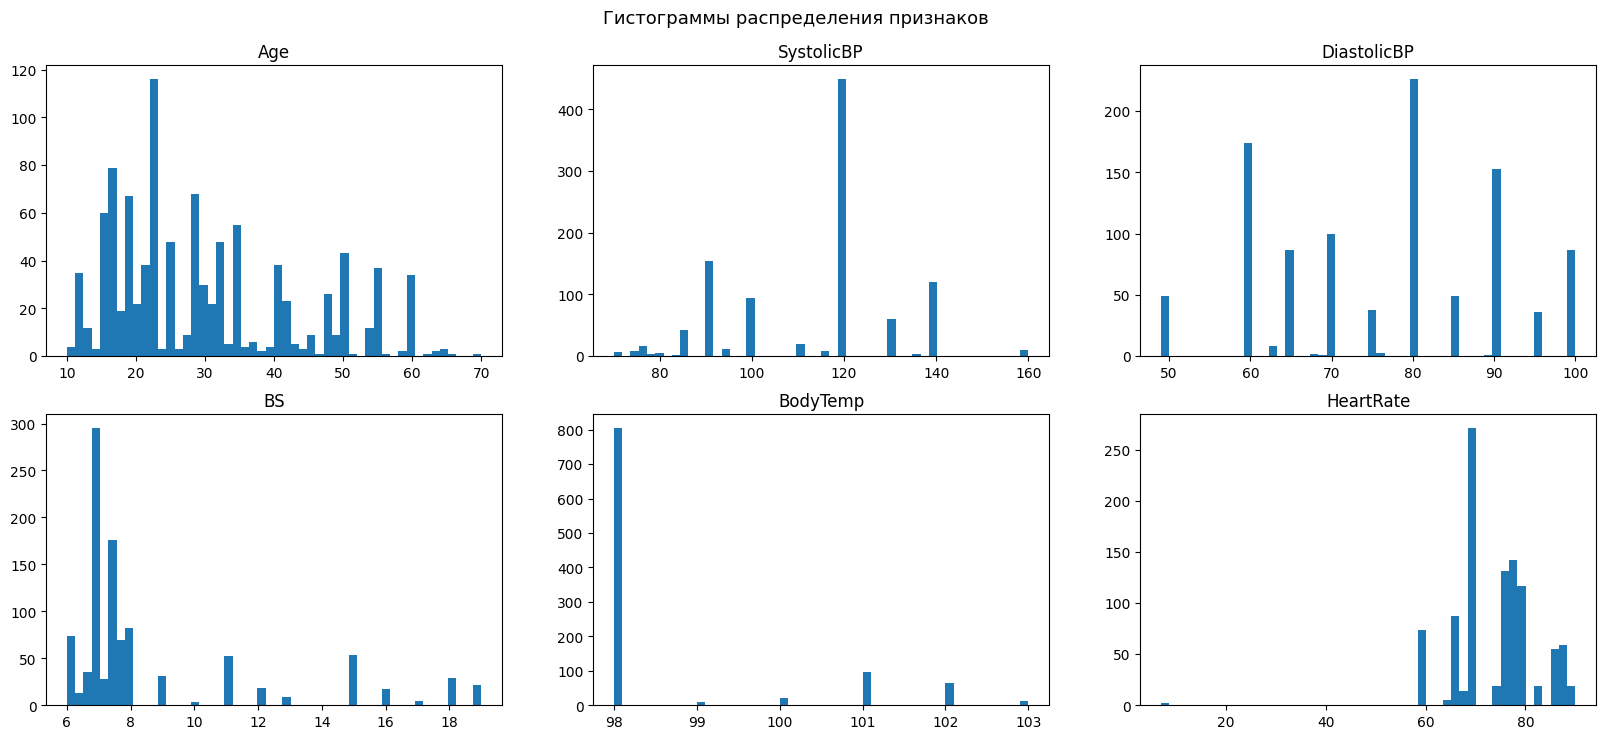

In [ ]:
num_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']

fig, axs = plt.subplots(2, 3, figsize=(20, 8))
plt.suptitle('Гистограммы распределения признаков', fontsize=13)
plt.subplots_adjust(top=0.91)

for i, col in enumerate(num_cols):
    axs[i//3, i%3].hist(df[col], bins=50)
    axs[i//3, i%3].set_title(col)

plt.show()

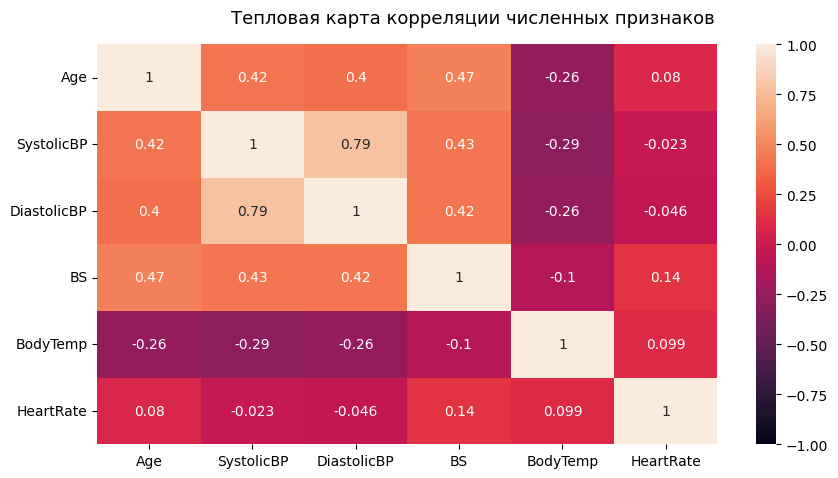

In [ ]:
# Проверяем данные на мультиколлинеарность
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(), vmax=1, vmin=-1, annot=True)
plt.suptitle('Тепловая карта корреляции численных признаков', fontsize=13)
plt.subplots_adjust(top=0.91)
plt.show()

In [ ]:
# Функция для исследования признаков на наличие выбросов и характер
def variable_boxplot(df, title, xlabel):
  plt.figure(figsize=[10,1])

  sns.boxplot(x = df)
  plt.title(title)
  plt.xlabel(xlabel)

  plt.show()

  print('Статистики признака')
  print(df.describe())
  print()
  print('Количество уникальных значений в признаке:',df.nunique(), sep='')
  print()
  print('Топ-10 самых частых значений')
  print(df.value_counts(ascending=False).head(10))
  print()
  print('*'*60)
  print()

In [ ]:
numeric_cols = list(df.columns[:-1])
numeric_cols

['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']

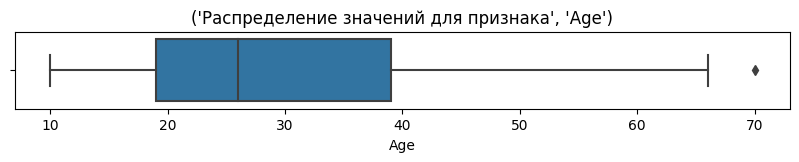

Статистики признака
count    1014.000000
mean       29.871795
std        13.474386
min        10.000000
25%        19.000000
50%        26.000000
75%        39.000000
max        70.000000
Name: Age, dtype: float64

Количество уникальных значений в признаке:50

Топ-10 самых частых значений
23    71
19    67
17    63
15    60
35    50
25    48
32    48
22    45
50    43
29    40
Name: Age, dtype: int64

************************************************************



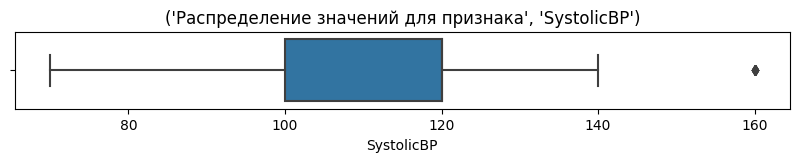

Статистики признака
count    1014.000000
mean      113.198225
std        18.403913
min        70.000000
25%       100.000000
50%       120.000000
75%       120.000000
max       160.000000
Name: SystolicBP, dtype: float64

Количество уникальных значений в признаке:19

Топ-10 самых частых значений
120    449
90     154
140    120
100     92
130     60
85      43
110     19
76      16
95      12
160     10
Name: SystolicBP, dtype: int64

************************************************************



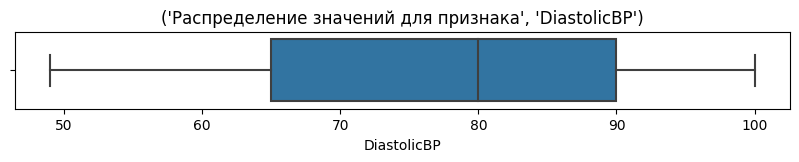

Статистики признака
count    1014.000000
mean       76.460552
std        13.885796
min        49.000000
25%        65.000000
50%        80.000000
75%        90.000000
max       100.000000
Name: DiastolicBP, dtype: float64

Количество уникальных значений в признаке:16

Топ-10 самых частых значений
80     226
60     174
90     153
70     100
100     87
65      87
85      49
75      38
95      36
49      25
Name: DiastolicBP, dtype: int64

************************************************************



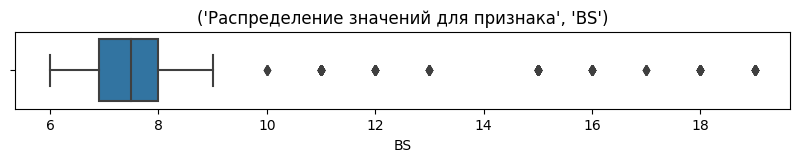

Статистики признака
count    1014.000000
mean        8.725986
std         3.293532
min         6.000000
25%         6.900000
50%         7.500000
75%         8.000000
max        19.000000
Name: BS, dtype: float64

Количество уникальных значений в признаке:29

Топ-10 самых частых значений
7.5     176
6.9     113
6.8      88
7.0      79
7.9      60
15.0     54
6.1      53
11.0     52
7.8      45
6.7      33
Name: BS, dtype: int64

************************************************************



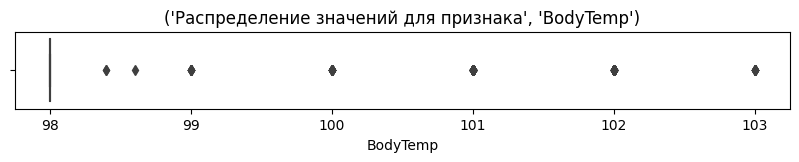

Статистики признака
count    1014.000000
mean       98.665089
std         1.371384
min        98.000000
25%        98.000000
50%        98.000000
75%        98.000000
max       103.000000
Name: BodyTemp, dtype: float64

Количество уникальных значений в признаке:8

Топ-10 самых частых значений
98.0     804
101.0     98
102.0     66
100.0     20
103.0     13
99.0      10
98.4       2
98.6       1
Name: BodyTemp, dtype: int64

************************************************************



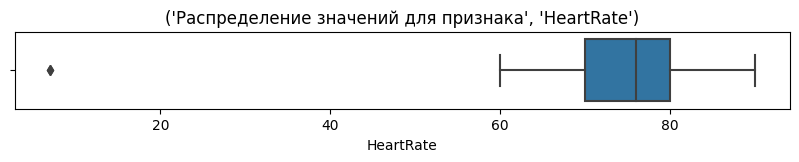

Статистики признака
count    1014.000000
mean       74.301775
std         8.088702
min         7.000000
25%        70.000000
50%        76.000000
75%        80.000000
max        90.000000
Name: HeartRate, dtype: float64

Количество уникальных значений в признаке:16

Топ-10 самых частых значений
70    271
76    131
80    117
77     96
66     87
60     74
88     59
86     55
78     46
90     19
Name: HeartRate, dtype: int64

************************************************************



In [ ]:
for col in numeric_cols:
  variable_boxplot(df[col], ('Распределение значений для признака',col), col)

In [ ]:
# Баланс классов в таргете
df.RiskLevel.value_counts(normalize=True)

low risk     0.400394
mid risk     0.331361
high risk    0.268245
Name: RiskLevel, dtype: float64

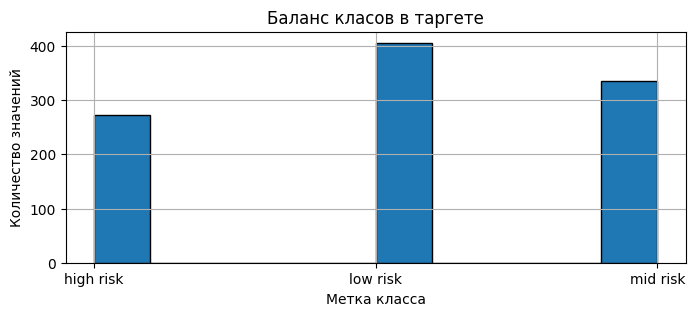

In [ ]:
# Построим гистограмму частотности классов в таргете
plt.figure(figsize=(8, 3))

df['RiskLevel'].hist(edgecolor='k')

plt.title('Баланс класов в таргете')
plt.xlabel('Метка класса')
plt.ylabel('Количество значений')
plt.xticks(rotation=0)
plt.show()

###**EDA. Вывод.**

- __Размер датасета.__
  - 1014 X 7
- __Формат признаков.__
  - Признаки в численном представлении, таргет - строка.
  - Приведение к другим типам не требуется.
- __Пропуски и дубликаты.__
  - Данные не имеют пропусков.
  - Количество явных дубликатов = 562. Учитывая смысловой характер данных(показатели организма), они не являются дубликатами, а указывают на совпадение показателей для разных наблюдений, и следовательно удалять их из датасета нельзя.
- __Распределение и характер признаков.__
  - Признаки имеют различный масштаб.
  - Признаки имеют ненормальное распределение.
  - Распределение признака `Age` приближено к нормальному.
- __Выбросы / аномалии.__
  - Почти во всех признаках среднее близко к медиане и присутствует минимальный процент выбросов.
- __Корреляция признаков / мультиколлинеарность.__
  - Признаки `SystolicBP` и `DiastolicBP` имеют относительно высокий коэффициент корреляции = 0.79.
  - В остальных признаках значимая корреляция отсутствует.
- __Баланс классов в таргете.__
  - Значения в таргете сбалансированы, доли классов следующие:
     - `low risk`  -   0.40
     - `mid risk`  -   0.33
     - `high risk` -   0.27

По итогу EDA данные готовы к моделированию. На этапе построения baseline никакой специальной предварительной обработки не потребуется. Возможно, при дальнейшей доработке baseline потребуется обработка выбросов.

## **4. Baseline**

В качестве baseline построим простой линейный классификатор на базе логистической регрессии.

Для оценки качества моделей будем использовать метрики precision, recall, f1_score, accuracy.

#### **4.1.Разделение данных на выборки**

In [ ]:
# Делим признаки на фичи и таргет:
X = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

In [ ]:
# Разбиваем на выборки - обучающую и тестовую:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

In [ ]:
# Выделяем из train валидационную выборку

# Но сначала создадим полную обучающую выборку, в которой объединены train и val
train_full_X = X_train
train_full_y = y_train

# Выделим валидационную выборку:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE, stratify=y_train)

# Проверим размеры сетов
print('Изначальный датафрейм после предобработки:', df.shape)
print('X_train:', X_train.shape)
print('X_valid:', X_valid.shape)
print('X_test:', X_test.shape)
print('Полный обучающий сет train_full_X:', train_full_X.shape)

Изначальный датафрейм после предобработки: (1014, 7)
X_train: (608, 6)
X_valid: (203, 6)
X_test: (203, 6)
Полный обучающий сет train_full_X: (811, 6)


#### **4.2.Фильтрация выбросов и формирование выборок на отфильтрованных данных**

Создадим второй набор выборок, сформированный на данных после удаления выбросов.

Фильтрацию выбросов будем делать по следующим условиям:

   - удаляем: `Age` > 65
   - удаляем: `HeartRate` < 60
   - удаляем: `SystolicBP` > 140
   - удаляем: `BS` > 9

In [ ]:
df_filtered = df.query('Age <=65 and HeartRate >= 60 and SystolicBP <=140 and BS <=9').copy()
df_eda(df_filtered)

Размер датафрейма: (800, 7) 

Столбцы и типы данных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 2 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          800 non-null    int64  
 1   SystolicBP   800 non-null    int64  
 2   DiastolicBP  800 non-null    int64  
 3   BS           800 non-null    float64
 4   BodyTemp     800 non-null    float64
 5   HeartRate    800 non-null    int64  
 6   RiskLevel    800 non-null    object 
dtypes: float64(2), int64(4), object(1)
memory usage: 50.0+ KB
None 

Общее кол-во пропусков:


0

Общее кол-во дубликатов в датафрейме:


422

In [ ]:
# Делим признаки на фичи и таргет:
X_filter = df_filtered.drop('RiskLevel', axis=1)
y_filter = df_filtered['RiskLevel']

In [ ]:
# Разбиваем на выборки - обучающую и тестовую:
X_filter_train, X_filter_test, y_filter_train, y_filter_test = train_test_split(
    X_filter,
    y_filter,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_filter
    )

In [ ]:
# Выделяем из train_filter валидационную выборку

# Но сначала создадим полную обучающую выборку, в которой объединены train и val
train_full_X_filter = X_filter_train
train_full_y_filter = y_filter_train

# Выделим валидационную выборку:
X_filter_train, X_filter_valid, y_filter_train, y_filter_valid = train_test_split(
    X_filter_train,
    y_filter_train,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y_filter_train
    )

# Проверим размеры сетов
print('Изначальный датафрейм после предобработки:', df_filtered.shape)
print('X_filter_train:', X_filter_train.shape)
print('X_filter_valid:', X_filter_valid.shape)
print('X_filter_test:', X_filter_test.shape)
print('Полный обучающий сет train_full_X_filter:', train_full_X_filter.shape)

Изначальный датафрейм после предобработки: (800, 7)
X_filter_train: (480, 6)
X_filter_valid: (160, 6)
X_filter_test: (160, 6)
Полный обучающий сет train_full_X_filter: (640, 6)


**Функция для вывода основных метрик**

In [ ]:
# Функция для вывода основных метрик
def get_metrics(X, y, model):

  '''Функция принимает на вход:
      - выборку для формирования предсказания
      - таргет для расчета метрик качества предсказания
      - модель
    Выдает рассчитанные метрики'''

  f1_macro = metrics.f1_score(y, model.predict(X), average='macro')
  accuracy = accuracy_score(y, model.predict(X))
  precision = precision_score(y, model.predict(X), average='macro')
  recall = recall_score(y, model.predict(X), average='macro')

  print('\033[1mМетрики\033[0m')
  print('F1-macro:', f1_macro.round(3))
  print('Accuracy:', accuracy.round(3))
  print('Precision:', precision.round(3))
  print('Recall:', recall.round(3))

#### **4.2. Моделирование baseline**

In [ ]:
%%time

model_base = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
model_base.fit(X_train, y_train)

CPU times: user 45.8 ms, sys: 72.5 ms, total: 118 ms
Wall time: 1.37 s


LogisticRegression(n_jobs=-1, random_state=42)

In [ ]:
get_metrics(X_valid, y_valid, model_base)

Метрики
F1-macro: 0.61
Accuracy: 0.621
Precision: 0.63
Recall: 0.613


## **5. Модели**

**МЕТРИКА**

Перед нами задача мультиклассовой классификации, поэтому целесообразно использовать для оценки микро- или макро-усреднение (micro-averaging и macro-averaging): они позволяют объединить показатели производительности по отдельным классам для получения общей оценки модели.

Микро-усреднение учитывает каждый экземпляр отдельно, тогда как макро-усреднение учитывает каждый класс одинаково.

Нам важно, чтобы даже самый малочисленный класс определялся с высокой точностью, поэтому возьмем метрику F1-мера в варианте macro - он считает f1-меру для каждой класса, а затем считает среднее значение. Из-за этого даже самый малый класс имеет одинаковый вес при расчёте средней метрики.

**Функция для вывода основных метрик при подборе гиперпараметров кросс-валидацией**

In [ ]:
# Функция для вывода основных метрик при подборе гиперпараметров кросс-валидацией
def get_metrics_gridsearchCV(model):

  '''Функция принимает на вход:
      - модель на базе GridSearchCV
    Выдает рассчитанные на валидационной выборке внутри GridSearchCV метрики для лучшей модели'''

  results = pd.DataFrame(model.cv_results_)

  f1_macro = results.at[model.best_index_, 'mean_test_f1_macro']
  accuracy = results.at[model.best_index_, 'mean_test_accuracy']
  precision = results.at[model.best_index_, 'mean_test_precision']
  recall = results.at[model.best_index_, 'mean_test_recall']

  print('\033[1mМетрики\033[0m') #, model.best_params_, '\033[1mна валидационной выборке\033[0m')
  print('F1-macro:', f1_macro.round(3))
  print('Accuracy:', accuracy.round(3))
  print('Precision:', precision.round(3))
  print('Recall:', recall.round(3))

#### **5.1. Логистическая регрессия на отмасштабированных данных**

In [ ]:
%%time

# Создаем пайплайн для логистической регрессии с предварительным масштабированием данных
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])

# Определяем сетку гиперпараметров для логистической регрессии
param_lr = {
    'classifier__C': [0.01, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

scoring = {
    'f1_macro': make_scorer(f1_score, pos_label=None, average='macro'),
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro')
    }

# Инициализируем GridSearchCV с пайплайном и сеткой гиперпараметров
model_lr = GridSearchCV(
    pipeline_lr,
    param_lr,
    cv=3,
    scoring=scoring,
    refit='f1_macro',
    verbose=10,
    n_jobs=-1,
    return_train_score = True
    )

# Обучаем модель с кросс-валидацией на полных данных
model_lr.fit(train_full_X, train_full_y)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
CPU times: user 113 ms, sys: 4.79 ms, total: 118 ms
Wall time: 1.52 s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 1, 10],
                         'classifier__penalty': ['l1', 'l2']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_macro': make_scorer(f1_score, pos_label=None, average=macro),
                      'precision': make_scorer(precision_score, average=macro),
                      'recall': make_scorer(recall_score, average=macro)},
             verbose=10)

In [ ]:
# Параметры лучшей модели
model_lr.best_params_

{'classifier__C': 0.01, 'classifier__penalty': 'l2'}

In [ ]:
get_metrics_gridsearchCV(model_lr)

Метрики
F1-macro: 0.609
Accuracy: 0.638
Precision: 0.644
Recall: 0.619


Масштабирование данных не дало прироста в метрике. Попробуем исследовать поочередное удаление признаков с относительно высоким коэффициентом корреляции.

#### **5.2. Логистическая регрессия на отмасштабированных данных c удалением одного из коррелирующих признаков**

In [ ]:
cols_for_drop = ['SystolicBP', 'DiastolicBP']

for col in cols_for_drop:
  train_full_X_drop = train_full_X.drop(col, axis=1).copy()

  # Создаем пайплайн для логистической регрессии с предварительным масштабированием данных
  pipeline_lr = Pipeline([
      ('scaler', StandardScaler()),
      ('classifier', LogisticRegression(random_state=RANDOM_STATE))
      ])

  # Определяем сетку гиперпараметров для логистической регрессии
  param_lr = {
      'classifier__C': [0.01, 1, 10],
      'classifier__penalty': ['l1', 'l2']
      }

  scoring = {
    'f1_macro': make_scorer(f1_score, pos_label=None, average='macro'),
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro')
    }


  # Инициализируем GridSearchCV с пайплайном и сеткой гиперпараметров
  model_lr_drop = GridSearchCV(
      pipeline_lr,
      param_lr,
      cv=3,
      scoring=scoring,
      refit='f1_macro',
      verbose=10,
      n_jobs=-1,
      return_train_score = True
      )

  # Обучаем модель с кросс-валидацией на данных с удалением признака
  model_lr_drop.fit(train_full_X_drop, train_full_y)

  # Выводим отчет по метрикам
  print('\033[1mРезультат для эксперимента с удалением столбца\033[0m', col)
  print()
  get_metrics_gridsearchCV(model_lr_drop)
  print()
  print('##############################################################')
  print()

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Результат для эксперимента с удалением столбца SystolicBP

Метрики
F1-macro: 0.556
Accuracy: 0.592
Precision: 0.599
Recall: 0.572

##############################################################

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Результат для эксперимента с удалением столбца DiastolicBP

Метрики
F1-macro: 0.597
Accuracy: 0.629
Precision: 0.639
Recall: 0.607

##############################################################



**ПРОМЕЖУТОЧНЫЙ ВЫВОД:**
Удаление любого из столбцов `SystolicBP`, `DiastolicBP` ухудшает метрику. Оставим все признаки, но теперь попробуем удалить выбросы.

#### **5.3. Логистическая регрессия на отмасштабированных данных после удаления выбросов**

In [ ]:
%%time

# Создаем пайплайн для логистической регрессии с предварительным масштабированием данных
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE))
])

# Определяем сетку гиперпараметров для логистической регрессии
param_lr = {
    'classifier__C': [0.01, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

scoring = {
    'f1_macro': make_scorer(f1_score, pos_label=None, average='macro'),
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro')
    }

# Инициализируем GridSearchCV с пайплайном и сеткой гиперпараметров
model_lr_filter = GridSearchCV(
    pipeline_lr,
    param_lr,
    cv=3,
    scoring=scoring,
    refit='f1_macro',
    verbose=10,
    n_jobs=-1,
    return_train_score = True
    )

# Обучаем модель с кросс-валидацией на полных данных
model_lr_filter.fit(train_full_X_filter, train_full_y_filter)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
CPU times: user 69.1 ms, sys: 3.89 ms, total: 73 ms
Wall time: 382 ms


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 1, 10],
                         'classifier__penalty': ['l1', 'l2']},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_macro': make_scorer(f1_score, pos_label=None, average=macro),
                      'precision': make_scorer(precision_score, average=macro),
                      'recall': make_scorer(recall_score, average=macro)},
             verbose=10)

In [ ]:
get_metrics_gridsearchCV(model_lr_filter)

Метрики
F1-macro: 0.526
Accuracy: 0.592
Precision: 0.567
Recall: 0.512


**ПРОМЕЖУТОЧНЫЙ ВЫВОД:**
Обученние модели на отфильтрованных данных(после удаления выбросов), существенно ухудшает качество предсказания: занчение F1-меры упало с 0.609 до 0.526.

Для логистической регрессии лучшим является вариант, обученный на полных данных с предварительным масштабированием.

В дальнейших экспериментах с моделями будем использовать полные данные без фильтрации.

#### **5.4. Случайный лес**

In [ ]:
%%time

# Создаем пайплайн для случайного леса с предварительным масштабированием данных
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=RANDOM_STATE))
])

# Определяем сетку гиперпараметров для случайного леса
param_rf = {
    'classifier__n_estimators': range(50, 151, 50),
    'classifier__max_depth': range(8, 10),
    'classifier__min_samples_split': (2, 3),
    'classifier__min_samples_leaf': (2, 3),
    'classifier__bootstrap': [True, False],
    'classifier__criterion': ['gini', 'entropy']
}

scoring = {
    'f1_macro': make_scorer(f1_score, pos_label=None, average='macro'),
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro')
    }

# Инициализируем GridSearchCV с пайплайном и сеткой гиперпараметров
model_rf = GridSearchCV(
    pipeline_rf,
    param_rf,
    cv=3,
    scoring = scoring,
    refit = 'f1_macro',
    verbose=10,
    n_jobs=-1,
    return_train_score = True
    )

# Обучаем модель с кросс-валидацией на полных данных
model_rf.fit(train_full_X, train_full_y)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
CPU times: user 1.99 s, sys: 203 ms, total: 2.19 s
Wall time: 1min 7s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': range(8, 10),
                         'classifier__min_samples_leaf': (2, 3),
                         'classifier__min_samples_split': (2, 3),
                         'classifier__n_estimators': range(50, 151, 50)},
             refit='f1_macro', return_train_score=True,
             scoring={'accuracy': make_scorer(accuracy_score),
                      'f1_macro': make_scorer(f1_score, pos_label=None, average=macro),
                      'precision': make_scorer(precision_score, average=macro),
                      'recall': make_scorer(recall_score, average=macro)},
             verbose=10)

In [ ]:
# Параметры лучшей модели
model_rf.best_params_

{'classifier__bootstrap': False,
 'classifier__criterion': 'gini',
 'classifier__max_depth': 9,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 150}

In [ ]:
get_metrics_gridsearchCV(model_rf)

Метрики
F1-macro: 0.792
Accuracy: 0.793
Precision: 0.798
Recall: 0.79


**ПРОМЕЖУТОЧНЫЙ ВЫВОД:**
Для модели RandomForestClassifier F1-мера выросла до 0.792.
Параметры модели:
 - 'classifier__bootstrap': False,
 - 'classifier__criterion': 'gini',
 - 'classifier__max_depth': 9,
 - 'classifier__min_samples_leaf': 2,
 - 'classifier__min_samples_split': 2,
 - 'classifier__n_estimators': 150

#### **5.5. Модель градиентного бустинга в реализации CatBoost**

Теперь попробуем алгоритм градиентного бустинга. Будем использовать его в реализации CatBoostClassifier(). В этой модели отлично настроены базовые параметры, что позволяет получить достаточно хорошее качество предсказания "из коробки". Поэтому подбор гиперпараметров делать не будем.

Масштабирование признаков и удаление коррелирующих признаков нам делать также не придется, поскольку модель CatBoostClassifier() не чувствительна к этим особенностям данных.

Таким образом, подавать будем сырые данные, без какой-либо предобработки.

In [ ]:
# Создадим пулы данных

train_data = Pool(data=X_train,
                  label=y_train
                 )

valid_data = Pool(data=X_valid,
                  label=y_valid
                 )

test_data = Pool(data=X_test,
                label=y_test
                )


train_full_data = Pool(data = train_full_X,
                       label = train_full_y
                      )

In [ ]:
# Прописываем параметры модели

params = {'verbose': 100,
         'random_seed': 42,
         'learning_rate': 0.01,
         'iterations': 1000,
         'loss_function' : 'MultiClass',
         'early_stopping_rounds': 500,
         'eval_metric': 'Accuracy',
         #'eval_metric': 'F1',
         'custom_metric': ['Accuracy','F1', 'Precision', 'Recall']
         #'task_type': "GPU",
         #'devices':'0:1',
         #'save_snapshot': False
         }

model_cb = CatBoostClassifier(**params)

In [ ]:
%%time

model_cb.fit(train_data, eval_set=valid_data)

0:	learn: 0.6628289	test: 0.6798030	best: 0.6798030 (0)	total: 48.2ms	remaining: 48.1s
100:	learn: 0.7500000	test: 0.7241379	best: 0.7389163 (66)	total: 172ms	remaining: 1.53s
200:	learn: 0.7746711	test: 0.7536946	best: 0.7586207 (195)	total: 282ms	remaining: 1.12s
300:	learn: 0.7796053	test: 0.7438424	best: 0.7586207 (195)	total: 399ms	remaining: 926ms
400:	learn: 0.7944079	test: 0.7389163	best: 0.7586207 (195)	total: 503ms	remaining: 751ms
500:	learn: 0.8125000	test: 0.7487685	best: 0.7586207 (195)	total: 605ms	remaining: 602ms
600:	learn: 0.8289474	test: 0.7487685	best: 0.7586207 (195)	total: 712ms	remaining: 473ms
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.7586206897
bestIteration = 195

Shrink model to first 196 iterations.
CPU times: user 1.15 s, sys: 208 ms, total: 1.36 s
Wall time: 1 s


In [ ]:
model_cb.get_best_score()

{'learn': {'Recall:class=0': 0.9141104294478528,
  'F1:class=2': 0.7731958762886598,
  'F1:class=0': 0.8868501529051989,
  'Recall:class=2': 0.7425742574257426,
  'Precision:class=1': 0.8372093023255814,
  'Precision:class=2': 0.8205128205128205,
  'Precision:class=0': 0.8841463414634146,
  'Recall:class=1': 0.9588477366255144,
  'MultiClass': 0.47486849167504025,
  'F1:class=1': 0.8622754491017963,
  'Accuracy': 0.8404605263157895},
 'validation': {'Recall:class=0': 0.9074074074074074,
  'F1:class=2': 0.6356589147286821,
  'F1:class=0': 0.8440366972477065,
  'Recall:class=2': 0.6119402985074627,
  'Precision:class=1': 0.7613636363636364,
  'Precision:class=2': 0.75,
  'Precision:class=0': 0.8490566037735849,
  'Recall:class=1': 0.9512195121951219,
  'MultiClass': 0.572210737762542,
  'F1:class=1': 0.8148148148148148,
  'Accuracy': 0.7586206896551724}}

In [ ]:
get_metrics(X_valid, y_valid, model_cb)

Метрики
F1-macro: 0.751
Accuracy: 0.759
Precision: 0.763
Recall: 0.755


**ПРОМЕЖУТОЧНЫЙ ВЫВОД:**
Метрика на градиентном бустинге ниже, чем на случайном лесе: F1-мера 0.751 против 0.792 на лесе.

#### **5.6. Результирующая таблица**

Для составления результирующей таблицы изменим функции для вывода метрик.

In [ ]:
# Функция для вывода основных метрик
def get_metrics_for_result_table(X, y, model):

  '''Функция принимает на вход:
      - выборку для формирования предсказания
      - таргет для расчета метрик качества предсказания
      - модель
    Выдает рассчитанные метрики'''

  f1_macro = metrics.f1_score(y, model.predict(X), average='macro')
  accuracy = accuracy_score(y, model.predict(X))
  precision = precision_score(y, model.predict(X), average='macro')
  recall = recall_score(y, model.predict(X), average='macro')

  return f1_macro, accuracy, precision, recall

In [ ]:
# Функция для вывода основных метрик при подборе гиперпараметров кросс-валидацией
def get_metrics_gridsearchCV_for_result_table(model):

  '''Функция принимает на вход:
      - модель на базе GridSearchCV
    Выдает рассчитанные на валидационной выборке внутри GridSearchCV метрики для лучшей модели'''

  results = pd.DataFrame(model.cv_results_)

  f1_macro = results.at[model.best_index_, 'mean_test_f1_macro']
  accuracy = results.at[model.best_index_, 'mean_test_accuracy']
  precision = results.at[model.best_index_, 'mean_test_precision']
  recall = results.at[model.best_index_, 'mean_test_recall']

  return f1_macro, accuracy, precision, recall

In [ ]:
# Получаем данные для результирующей таблицы
f1_base, accuracy_base, precision_base, recall_base = get_metrics_for_result_table(X_valid, y_valid, model_base)
f1_macro_lr, accuracy_lr, precision_lr, recall_lr = get_metrics_gridsearchCV_for_result_table(model_lr)
f1_macro_rf, accuracy_rf, precision_rf, recall_rf = get_metrics_gridsearchCV_for_result_table(model_rf)
f1_macro_cb, accuracy_cb, precision_cb, recall_cb = get_metrics_for_result_table(X_valid, y_valid, model_cb)

In [ ]:
# Подготовим результирующую таблицу

result_table = pd.DataFrame(
    {'Model':
     [
         'Baseline',
         'LogisticRegression()',
         'RandomForestClassifier()',
         'CatBoostClassifier()'
         ],
     'F1-score':
      [
          f1_base.round(3),
          f1_macro_lr.round(3),
          f1_macro_rf.round(3),
          f1_macro_cb.round(3)
          ],
     'Accuracy':
      [
          accuracy_base.round(3),
          accuracy_lr.round(3),
          accuracy_rf.round(3),
          accuracy_cb.round(3)
          ],
     'Precision':
      [
          precision_base.round(3),
          precision_lr.round(3),
          precision_rf.round(3),
          precision_cb.round(3)
          ],
     'Recall':
      [
          recall_base.round(3),
          recall_lr.round(3),
          recall_rf.round(3),
          recall_cb.round(3)
          ]
     }
    )

In [ ]:
result_table.style.background_gradient(cmap='YlOrRd')

,Model,F1-score,Accuracy,Precision,Recall
0,Baseline,0.610000,0.621000,0.630000,0.613000
1,LogisticRegression(),0.609000,0.638000,0.644000,0.619000
2,RandomForestClassifier(),0.792000,0.793000,0.798000,0.790000
3,CatBoostClassifier(),0.751000,0.759000,0.763000,0.755000


**ПРОМЕЖУТОЧНЫЙ ВЫВОД:**
Лучшие метрики у модели RandomForestClassifier. Переходим к тестированию финальной модели.

## **6. Тестирование финальной модели**

#### **6.1. Тестирование**

In [ ]:
get_metrics(X_test, y_test, model_rf)

Метрики
F1-macro: 0.75
Accuracy: 0.744
Precision: 0.767
Recall: 0.745


In [ ]:
classification = metrics.classification_report(y_test, model_rf.predict(X_test))
print("Classification report for test:" "\n", classification)

Classification report for test:
               precision    recall  f1-score   support

   high risk       0.96      0.87      0.91        55
    low risk       0.68      0.84      0.75        81
    mid risk       0.66      0.52      0.58        67

    accuracy                           0.74       203
   macro avg       0.77      0.74      0.75       203
weighted avg       0.75      0.74      0.74       203



In [ ]:
# Расчитываем метрику ROC-AUC
probabilities_test = model_rf.predict_proba(X_test)
auc_roc = roc_auc_score(y_test, probabilities_test, average='macro', multi_class='ovr')
print('AUC-ROC на тесте: AUC-ROC = {:.2f}'.format(auc_roc))

AUC-ROC на тесте: AUC-ROC = 0.93


**ПРОМЕЖУТОЧНЫЙ ВЫВОД:**

Метрики, полученные на тесте:

  - F1-macro: 0.750
  - Accuracy: 0.744
  - Precision: 0.767
  - Recall: 0.745
  - AUC-ROC: 0.93

  Самую высокую точность предсказания модель выдает для класса `high risk`:
   - precision = 0.96
   - recall = 0.87
   - f1 = 0.91

  Хуже всего модель предсказывает класс `mid risk`:
   - precision = 0.66
   - recall = 0.52
   - f1 = 0.58  

#### **6.2. Матрица ошибок**

Поскольку у нас не бинарная, а многокласовая классификация, для построения матрицы ошибок необходимо использовать метод multilabel_confusion_matrix: он выдает массив матриц ошибок для каждого класса по принципе "один против всех".

In [ ]:
# Выводим список классов в таргете
labels = list(df.RiskLevel.unique())
labels

['high risk', 'low risk', 'mid risk']

In [ ]:
# Считаем матрицы ошибок для каждого класса
multilabel_confusion_matrix_for_test = metrics.multilabel_confusion_matrix(
    y_test,
    model_rf.predict(X_test),
    labels=["high risk", "low risk", "mid risk"])

In [ ]:
multilabel_confusion_matrix_for_test

array([[[146,   2],
        [  7,  48]],

       [[ 90,  32],
        [ 13,  68]],

       [[118,  18],
        [ 32,  35]]])

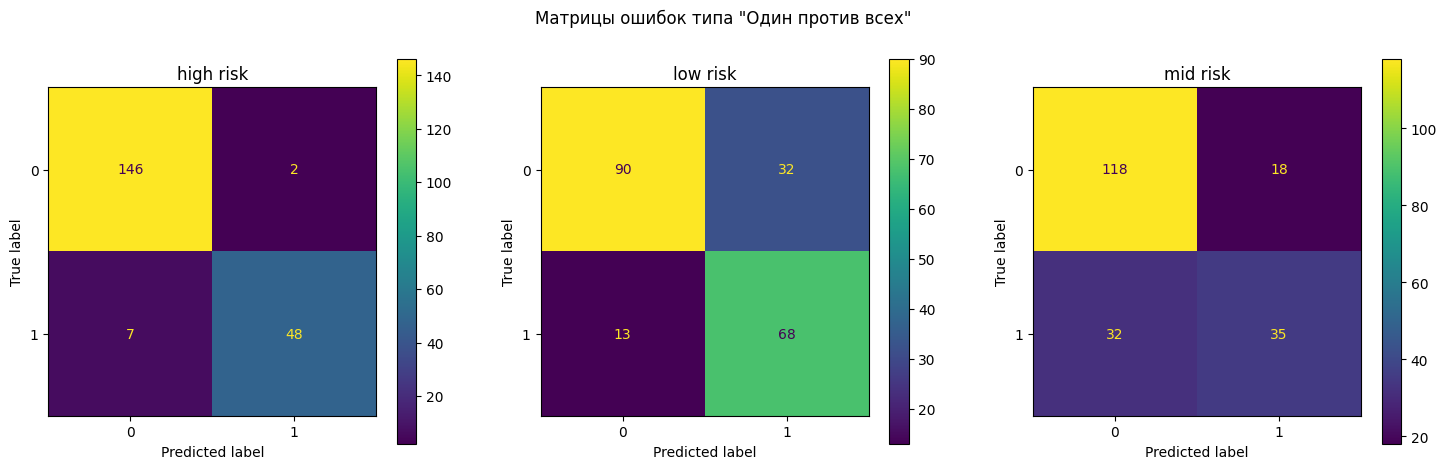

In [ ]:
# Строим визуализацию для матриц
fig, axs = plt.subplots(ncols=3, figsize=(18, 5))

for confusion_matrix, label, ax in zip(multilabel_confusion_matrix_for_test, labels, axs):
  disp = ConfusionMatrixDisplay(confusion_matrix)
  disp.plot(include_values=True, cmap="viridis", ax=ax)
  ax.set_title(label)

plt.suptitle('Матрицы ошибок типа "Один против всех"')
plt.show()

**ПРОМЕЖУТОЧНЫЙ ВЫВОД:**

Несмотря на относительно неплохие усредненные метрики, наша модель выдает довольно ощутимые доли ложно-отрицательных ответов:

  - **Класс `high risk`:** В 7 случаях из 203(размер тестовой выборки), т.е. в 3,5% случаев, алгоритм пропускает высокий риск, предсказывая, что его нет.
  - **Класс `low risk`:** В 6,4% случаев модель пропускает низкий риск осложнения беременности.
  - **Класс `mid risk`:** Тут самая большая просадка: модель пропускает средний риск осложнения беременности в 15,8% случаев.


## **7. Итоговый вывод.**

## Результат работы.
  - Значение максимальной целевой метрики `F1-macro` 0.750 было достигнуто с использованием модели `RandomForestClassifier()` с параметрами:
    - 'bootstrap': False,
    - 'criterion': 'gini',
    - 'max_depth': 9,
    - 'min_samples_leaf': 2,
    - 'min_samples_split': 2,
    - 'n_estimators': 150.
  - на смасштабированных с помощью `StandardScaler` данных.

  - Метрики, полученные на тестовой выборке:
      - F1-macro: 0.750
      - Accuracy: 0.744
      - Precision: 0.767
      - Recall: 0.745
      - AUC-ROC: 0.93

## Задача.
  - Был разработан алгоритм, который предсказывает риск осложнения беременности. Алгоритм выдает один из трёх вариантов предсказания:
      - `high risk`,
      - `low risk`,
      - `mid risk`

## Особенности полученного решения.
  - Самую высокую точность предсказания модель выдает для класса `high risk`:
   - precision = 0.96
   - recall = 0.87
   - f1 = 0.91
  - Хуже всего модель предсказывает класс `mid risk`:
   - precision = 0.66
   - recall = 0.52
   - f1 = 0.58
  - Для класса `low risk` показатели модели следующие:
   - precision = 0.68
   - recall = 0.84
   - f1 = 0.75

## Использовавшиеся в исследовании модели.
`LogisticRegression()`/ `RandomForestClassifier()`/ `CatBoostClassifier()`.

## Рекомендации / возможные направления улучшения точности прогноза.

Несмотря на относительно неплохие усредненные метрики, наша модель выдает довольно ощутимые доли ложно-отрицательных ответов:

  - **Класс `high risk`:** В 7 случаях из 203(размер тестовой выборки), т.е. в 3,5% случаев, алгоритм пропускает высокий риск, предсказывая, что его нет.
  - **Класс `low risk`:** В 6,4% случаев модель пропускает низкий риск осложнения беременности.
  - **Класс `mid risk`:** Тут самая большая просадка: модель пропускает средний риск осложнения беременности в 15,8% случаев.

Учитывая предмет прогноза (риск осложнения беременности), основной вопрос - как минимизировать ложно-отрицательные объекты?

Самый очевидный ответ - собрать больше данных. Можно попробовать размножить имеющиеся данные с помощью Upsampling.

Поскольку изначально не стояла задача добиться определенного уровня качества, эксперименты по возможному улучшению оставлены на последующую доработку проекта.
